In [2]:
!pip install torch torchvision torchmetrics kaggle kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 50.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [3]:
import kagglehub

path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")
path

100%|██████████| 714M/714M [00:32<00:00, 23.0MB/s]

Extracting files...


'/root/.cache/kagglehub/datasets/mateuszbuda/lgg-mri-segmentation/versions/2'

In [9]:
import os

dataset_base = path
dataset_base = f"{dataset_base}/{os.listdir(dataset_base)[0]}"
dataset_base = f"{dataset_base}/{os.listdir(dataset_base)[0]}"
dataset_base = f"{dataset_base}/{os.listdir(dataset_base)[0]}"
dataset_base

'/root/.cache/kagglehub/datasets/mateuszbuda/lgg-mri-segmentation/versions/2/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208'

In [10]:
os.listdir(dataset_base)[:5]

['TCGA_CS_4944_20010208_1_mask.tif',
 'TCGA_CS_4944_20010208_12_mask.tif',
 'TCGA_CS_4944_20010208_9_mask.tif',
 'TCGA_CS_4944_20010208_9.tif',
 'TCGA_CS_4944_20010208_16_mask.tif']

In [11]:
import torch.utils.data as data

class SegmentationDataset(data.Dataset):
  def __init__(self, path):
    super(SegmentationDataset, self).__init__()

    self.imgs = [f"{path}/{f}" for f in os.listdir(path) if '_mask' not in f]
    self.masks = [f"{path}/{f}" for f in os.listdir(path) if '_mask' in f]

  def __getitem__(self, index):
    from PIL import Image
    import numpy as np
    import torch
    img, mask = Image.open(self.imgs[index]), Image.open(self.masks[index])
    img, mask = img.resize((128,128)), mask.resize((128,128))
    img, mask = np.array(img), np.array(mask)
    img, mask = torch.from_numpy(img).float(), torch.from_numpy(mask).float()
    img, mask = img / 255., mask / 255.
    return img.permute((2,0,1)), mask

  def __len__(self):
    return len(self.imgs)

In [12]:
dataset = SegmentationDataset(dataset_base)
dataset

In [13]:
# verify data
for data in dataset:
  print(data[0].min(), data[0].max())
  print(data[0].shape, data[1].shape)
  break

tensor(0.) tensor(0.8980)
torch.Size([3, 128, 128]) torch.Size([128, 128])


In [14]:
import torch.nn as nn

class UNet(nn.Module):
  def __init__(self):
    super().__init__()

    # Encoder

    # formula: (size + 2 * padding - filter_size) / stride + 1
    # (128 + 2*1 - 3) / 1 + 1 = 128
    self.conv11 = nn.Conv2d(3, 64, 3, 1, 1)
    # (128 + 2*1 - 3) / 1 + 1 = 128
    self.conv12 = nn.Conv2d(64, 64, 3, 1, 1)
    # 128 / 2 = 64
    self.pool1 = nn.MaxPool2d(2, 2)

    # (64 + 2*1 - 3) / 1 + 1 = 64
    self.conv21 = nn.Conv2d(64, 128, 3, 1, 1)
    # (64 + 2*1 - 3) / 1 + 1 = 64
    self.conv22 = nn.Conv2d(128, 128, 3, 1, 1)
    # 64 / 2 = 32
    self.pool2 = nn.MaxPool2d(2, 2)

    # 32
    self.conv31 = nn.Conv2d(128, 256, 3, 1, 1)
    # 32
    self.conv32 = nn.Conv2d(256, 256, 3, 1, 1)
    # 32 / 2 = 16
    self.pool3 = nn.MaxPool2d(2, 2)


    self.conv41 = nn.Conv2d(256, 512, 3, 1, 1)
    self.conv42 = nn.Conv2d(512, 512, 3, 1, 1)


    # Decoder

    self.convT1 = nn.ConvTranspose2d(512, 256, 2, 2)
    self.convDec11 = nn.Conv2d(512, 256, 3, 1, 1)
    self.convDec12 = nn.Conv2d(256, 256, 3, 1, 1)

    self.convT2 = nn.ConvTranspose2d(256, 128, 2, 2)
    self.convDec21 = nn.Conv2d(256, 128, 3, 1, 1)
    self.convDec22 = nn.Conv2d(128, 128, 3, 1, 1)

    self.convT3 = nn.ConvTranspose2d(128, 64, 2, 2)
    self.convDec31 = nn.Conv2d(128, 64, 3, 1, 1)
    self.convDec32 = nn.Conv2d(64, 64, 3, 1, 1)

    self.convFinal = nn.Conv2d(64, 2, 1)

  def forward(self, x):
    from torch.nn.functional import relu
    import torch

    encoderC11 = relu(self.conv11(x))
    encoderC12 = relu(self.conv12(encoderC11))
    encoderP1 = self.pool1(encoderC12)

    encoderC21 = relu(self.conv21(encoderP1))
    encoderC22 = relu(self.conv22(encoderC21))
    encoderP2 = self.pool2(encoderC22)

    encoderC31 = relu(self.conv31(encoderP2))
    encoderC32 = relu(self.conv32(encoderC31))
    encoderP3 = self.pool3(encoderC32)


    bottleneckC1 = relu(self.conv41(encoderP3))
    bottleneckC2 = relu(self.conv42(bottleneckC1))


    decoderCT1 = self.convT1(bottleneckC2)
    skip1 = torch.cat([decoderCT1, encoderC32], dim=1)
    decoderC11 = relu(self.convDec11(skip1))
    decoderC12 = relu(self.convDec12(decoderC11))

    decoderCT2 = self.convT2(decoderC12)
    skip2 = torch.cat([decoderCT2, encoderC22], dim=1)
    decoderC21 = relu(self.convDec21(skip2))
    decoderC22 = relu(self.convDec22(decoderC21))

    decoderCT3 = self.convT3(decoderC22)
    skip3 = torch.cat([decoderCT3, encoderC12], dim=1)
    decoderC31 = relu(self.convDec31(skip3))
    decoderC32 = relu(self.convDec32(decoderC31))

    pred = self.convFinal(decoderC32)

    return pred


In [15]:
model = UNet()

In [16]:
# verify it works
import torch

for data in dataset:
  # stack to make batch size of 2
  X = torch.stack([data[0], data[0]])
  y = torch.stack([data[1], data[1]])
  pred = model(X)
  print(pred.shape, y.shape)
  print(pred.argmax(axis=1).shape)
  break

torch.Size([2, 2, 128, 128]) torch.Size([2, 128, 128])
torch.Size([2, 128, 128])


In [17]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, collate_fn=lambda x: x)

In [71]:
class DiceLoss(torch.nn.Module):
  def __init__(self):
    super(DiceLoss, self).__init__()

  def forward(self, preds, targets):
    preds = torch.nn.functional.sigmoid(preds)

    preds = preds.contiguous().view(-1)
    targets = targets.contiguous().view(-1)

    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()

    return 1 - ((2. * intersection + 1) / (union + 1))

In [79]:
from time import time


opt = torch.optim.SGD(params=model.parameters())
dice_loss = DiceLoss()
model.to(device)

n_epochs = 500
for epoch in range(1, n_epochs+1):
  print(f"Epoch {epoch}", end='')

  start = time()
  loss_per_epoch = 0
  for batch in dataloader:
    X = []
    y = []
    for data in batch:
      X.append(data[0])
      y.append(data[1])
    X = torch.stack(X)
    y = torch.stack(y)

    # B x W x H -> B x W x H x 2 -> B x 2 x W x H
    y = torch.nn.functional.one_hot(y.long(), num_classes=2).permute(0,3,1,2)

    if device == 'cuda':
      X = X.cuda()
      y = y.cuda()

    preds = model(X)

    loss = dice_loss(preds, y)
    loss_per_epoch += loss

    opt.zero_grad()
    loss.backward()
    opt.step()

  end = time()
  print(f" | Loss: {loss_per_epoch} [{end - start:.2f}s]", end='\n')

Epoch 1 | Loss: 1.2132916450500488 [0.27s]
Epoch 2 | Loss: 1.2080280780792236 [0.21s]
Epoch 3 | Loss: 1.2028231620788574 [0.20s]
Epoch 4 | Loss: 1.1976745128631592 [0.19s]
Epoch 5 | Loss: 1.1925809383392334 [0.19s]
Epoch 6 | Loss: 1.187541127204895 [0.19s]
Epoch 7 | Loss: 1.1825532913208008 [0.19s]
Epoch 8 | Loss: 1.1776164770126343 [0.19s]
Epoch 9 | Loss: 1.1727288961410522 [0.19s]
Epoch 10 | Loss: 1.1678895950317383 [0.19s]
Epoch 11 | Loss: 1.1630971431732178 [0.19s]
Epoch 12 | Loss: 1.1583504676818848 [0.19s]
Epoch 13 | Loss: 1.1536481380462646 [0.19s]
Epoch 14 | Loss: 1.148989200592041 [0.19s]
Epoch 15 | Loss: 1.1443724632263184 [0.19s]
Epoch 16 | Loss: 1.1397966146469116 [0.19s]
Epoch 17 | Loss: 1.1352605819702148 [0.19s]
Epoch 18 | Loss: 1.130763053894043 [0.19s]
Epoch 19 | Loss: 1.1263035535812378 [0.19s]
Epoch 20 | Loss: 1.1218805313110352 [0.19s]
Epoch 21 | Loss: 1.1174933910369873 [0.19s]
Epoch 22 | Loss: 1.1131408214569092 [0.19s]
Epoch 23 | Loss: 1.108821988105774 [0.19s]
E

In [80]:
torch.save(model.state_dict(), './trained-unet.pth')

In [81]:
model.load_state_dict(torch.load('./trained-unet.pth', weights_only=True))
model.eval()

UNet(
  (conv11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convT1): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
  (convDec11): Conv2d(512, 25

In [82]:
X = []
y = []
preds = None
for batch in dataloader:
  for data in batch:
    X.append(data[0])
    y.append(data[1])
  X = torch.stack(X)
  y = torch.stack(y)

  y = torch.nn.functional.one_hot(y.long(), num_classes=2).permute(0,3,1,2)

  if device == 'cuda':
    X = X.cuda()
    y = y.cuda()

  preds = model(X)
  break

In [83]:
preds.shape, y.shape

(torch.Size([8, 2, 128, 128]), torch.Size([8, 2, 128, 128]))

In [112]:
from torchmetrics import Dice, JaccardIndex

dice = Dice().to(device)
iou = JaccardIndex(task='multiclass', num_classes=2).to(device)
dice(preds, y), iou(torch.nn.functional.sigmoid(preds), y)

(tensor(0.9770, device='cuda:0'), tensor(0.2500, device='cuda:0'))

tensor(1) tensor(0)


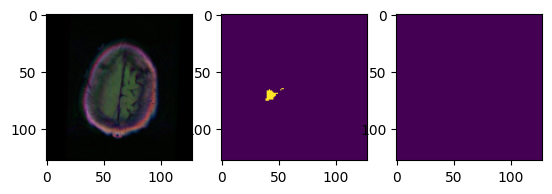

In [108]:
import matplotlib.pyplot as plt


num = 1

# print(X.shape, y.shape)
img = X[num].permute(1,2,0).cpu()
target = y[num].permute(1,2,0).argmax(axis=-1).cpu()
predicted = torch.nn.functional.sigmoid(preds[num].permute(1,2,0)).argmax(axis=-1).cpu()
# print(img.shape, target.shape, predicted.shape)
print(target.max(), predicted.max())


fig, ax = plt.subplots(1,3)
ax = ax.ravel()

ax[0].imshow(img)
ax[1].imshow(target)
ax[2].imshow(predicted)
plt.show()